# Run Regressions

This short notebook runs ridge regressions on pre-featurized data matrix with 2048 RCF features using a 5-fold cross-validation approach for all 7 labels used in the study. It saves the performance indexed by the filter size used in feature extraction.

## Settings

Here are the settings you can adjust when running this notebook:
- ``num_threads``: If running on a multi-core machine, change this from ``None`` to an ``int`` in order to set the max number of threads to use
- ``subset_[n,feat]``: If you want to subset the training set data for quick tests/debugging, specify that here using the `slice` object. `slice(None)` implies no subsetting of the ~80k observations for each label that are in the training set. `subset_n` slices observations; `subset_feat` subsets features.
- ``overwrite``: By default, this code will raise an error if the file you are saving already exists. If you would like to disable that and overwrite existing data files, change `overwrite` to `True`.
- ``labels_to_run``: By default, this notebook will loop through all the labels. If you would like, you can reduce this list to only loop through a subset of them, by changing ``"all"`` to a list of task names, e.g. ``["housing", "treecover"]``

In [13]:
num_threads = None

subset_n = slice(None)
subset_feat = slice(None)

overwrite = True

labels_to_run = "all"

### Imports

In [14]:
%load_ext autoreload
%autoreload 2

import io as b_io
import os
from pathlib import Path

import dill

import seaborn as sns

# Import necessary packages
from mosaiks import transforms
from mosaiks.utils import OVERWRITE_EXCEPTION
from mosaiks.utils.imports import *
from threadpoolctl import threadpool_limits

if num_threads is not None:
    threadpool_limits(num_threads)
    os.environ["NUMBA_NUM_THREADS"] = str(num_threads)

if labels_to_run == "all":
    labels_to_run = c.app_order

sns.set(context="paper", style="ticks")

# use Ridge on mosaiks features
solver = solve.ridge_regression

## Get save dir
if (subset_n != slice(None)) or (subset_feat != slice(None)):
    subset_str = "_subset"
else:
    subset_str = ""
figdir = Path(c.res_dir, "figures", "FigS6")
figdir.mkdir(exist_ok=True, parents=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def get_X_latlon_featSizeExp(c, sampling_type, patch_size):
    """Similar to get_X_latlon but for the feature size experiments"""

    # Load the feature matrix locally
    local_path = (
        Path(c.features_dir)
        / "patch_size_experiment"
        / f"patch_size_{patch_size}_1024_filters_{c.grid['area']}_{sampling_type}.pkl"
    )

    with open(local_path, "rb") as f:
        data = dill.load(f)

    X = data["X"].astype("float64")
    ids_x = data["ids_X"]
    latlons = data["latlon"]

    X = pd.DataFrame(
        X,
        index=ids_x,
        columns=["X_" + str(i) for i in range(X.shape[1])],
    )
    latlons = pd.DataFrame(latlons, index=ids_x, columns=["lat", "lon"])

    # sort both X and latlons
    latlons = latlons.sort_values(["lat", "lon"], ascending=[False, True])
    X = X.reindex(latlons.index)

    return X, latlons

## Run regressions

In [ ]:
resultsDict = {}
patch_sizes = [1, 2, 3, 6, 12, 24]
for patch_size in patch_sizes:

    ## Load Random Feature Data
    # This loads our feature matrix `X` for both POP and UAR samples
    X = {}
    latlons = {}

    X["UAR"], latlons["UAR"] = get_X_latlon_featSizeExp(c, "UAR", patch_size)
    X["POP"], latlons["POP"] = get_X_latlon_featSizeExp(c, "POP", patch_size)

    ## Run regressions
    # The following loop will:
    # 1. Load the appropriate labels
    # 2. Merge them with the feature matrix
    # 3. Remove test set observations
    # 4. Run a ridge regression on the training/validation set, sweeping over a range of possible
    #    regularization parameters using 5-fold Cross-Validation and clipping predictions to
    #    pre-specified bounds.
    # 5. Save the out-of-sample predictions and the observations for use in Figure 2.

    for label in labels_to_run:

        print("*** Running regressions for: {}".format(label))

        ## Set some label-specific variables
        this_cfg = io.get_filepaths(c, label)
        c_app = getattr(this_cfg, label)
        sampling_type = c_app["sampling"]  # UAR or POP

        if c_app["logged"]:
            bounds = np.array([c_app["us_bounds_log_pred"]])
        else:
            bounds = np.array([c_app["us_bounds_pred"]])

        # Set solver arguments
        solver_kwargs = {
            "lambdas": c_app["lambdas_patchSize"],
            "return_preds": True,
            "svd_solve": False,
            "clip_bounds": bounds,
        }

        ## get X, Y, latlon values of training data
        (
            this_X,
            this_X_test,
            this_Y,
            this_Y_test,
            _,
            _,
        ) = parse.merge_dropna_transform_split_train_test(
            this_cfg, label, X[sampling_type], latlons[sampling_type]
        )

        this_X = this_X[subset_n, subset_feat]
        this_X_test = this_X_test[:, subset_feat]
        this_Y = this_Y[subset_n]

        ## Train model using ridge regression and 5-fold cross-valiation
        ## (number of folds can be adjusted using the argument n_folds)
        print("Training model...")
        kfold_results = solve.kfold_solve(
            this_X,
            this_Y,
            solve_function=solver,
            num_folds=this_cfg.ml_model["n_folds"],
            return_model=True,
            **solver_kwargs
        )
        print("")

        ## Store the metrics and the predictions from the best performing model
        best_lambda_idx, best_metrics, best_preds = ir.interpret_kfold_results(
            kfold_results, "r2_score", hps=[("lambdas", solver_kwargs["lambdas"])]
        )

        ## Retrain a model using this best lambda:
        holdout_results = solve.single_solve(
            this_X,
            this_X_test,
            this_Y,
            this_Y_test,
            lambdas=solver_kwargs["lambdas"][best_lambda_idx],
            return_preds=True,
            return_model=False,
            clip_bounds=bounds,
        )

        ## Store the R2
        resultsDict[label + "_" + str(patch_size)] = holdout_results["metrics_test"][0][
            0
        ][0]["r2_score"]

## Print and save a table of the test set R2s and the figure

**Note:** This will only *update* the table with the labels and patch sizes you've run in this notebook. If you didn't run a given label or patch size, the previously calculated value will remain in the table.

### Table

In [ ]:
## convert to Series
res = pd.Series(resultsDict)
labels = [i.split("_")[0] for i in res.index]
patch_sizes = [int(i.split("_")[1]) for i in res.index]
res = pd.Series(
    res.values,
    index=pd.MultiIndex.from_arrays(
        (labels, patch_sizes), names=["label", "patch_size"]
    ),
    name="r2_score",
)

fn = figdir / f"R2_by_patch_size{subset_str}.csv"

if os.path.isfile(fn):
    if not overwrite:
        raise OVERWRITE_EXCEPTION

    # load existing data
    if fn.is_file():
        old = pd.read_csv(fn, index_col=[0, 1]).r2_score

        # update
        new_in_old = res.index.isin(old.index)
        res = old.drop(res.index[new_in_old]).append(res).sort_index()

# save
res.to_csv(fn, index=True)

### Figure

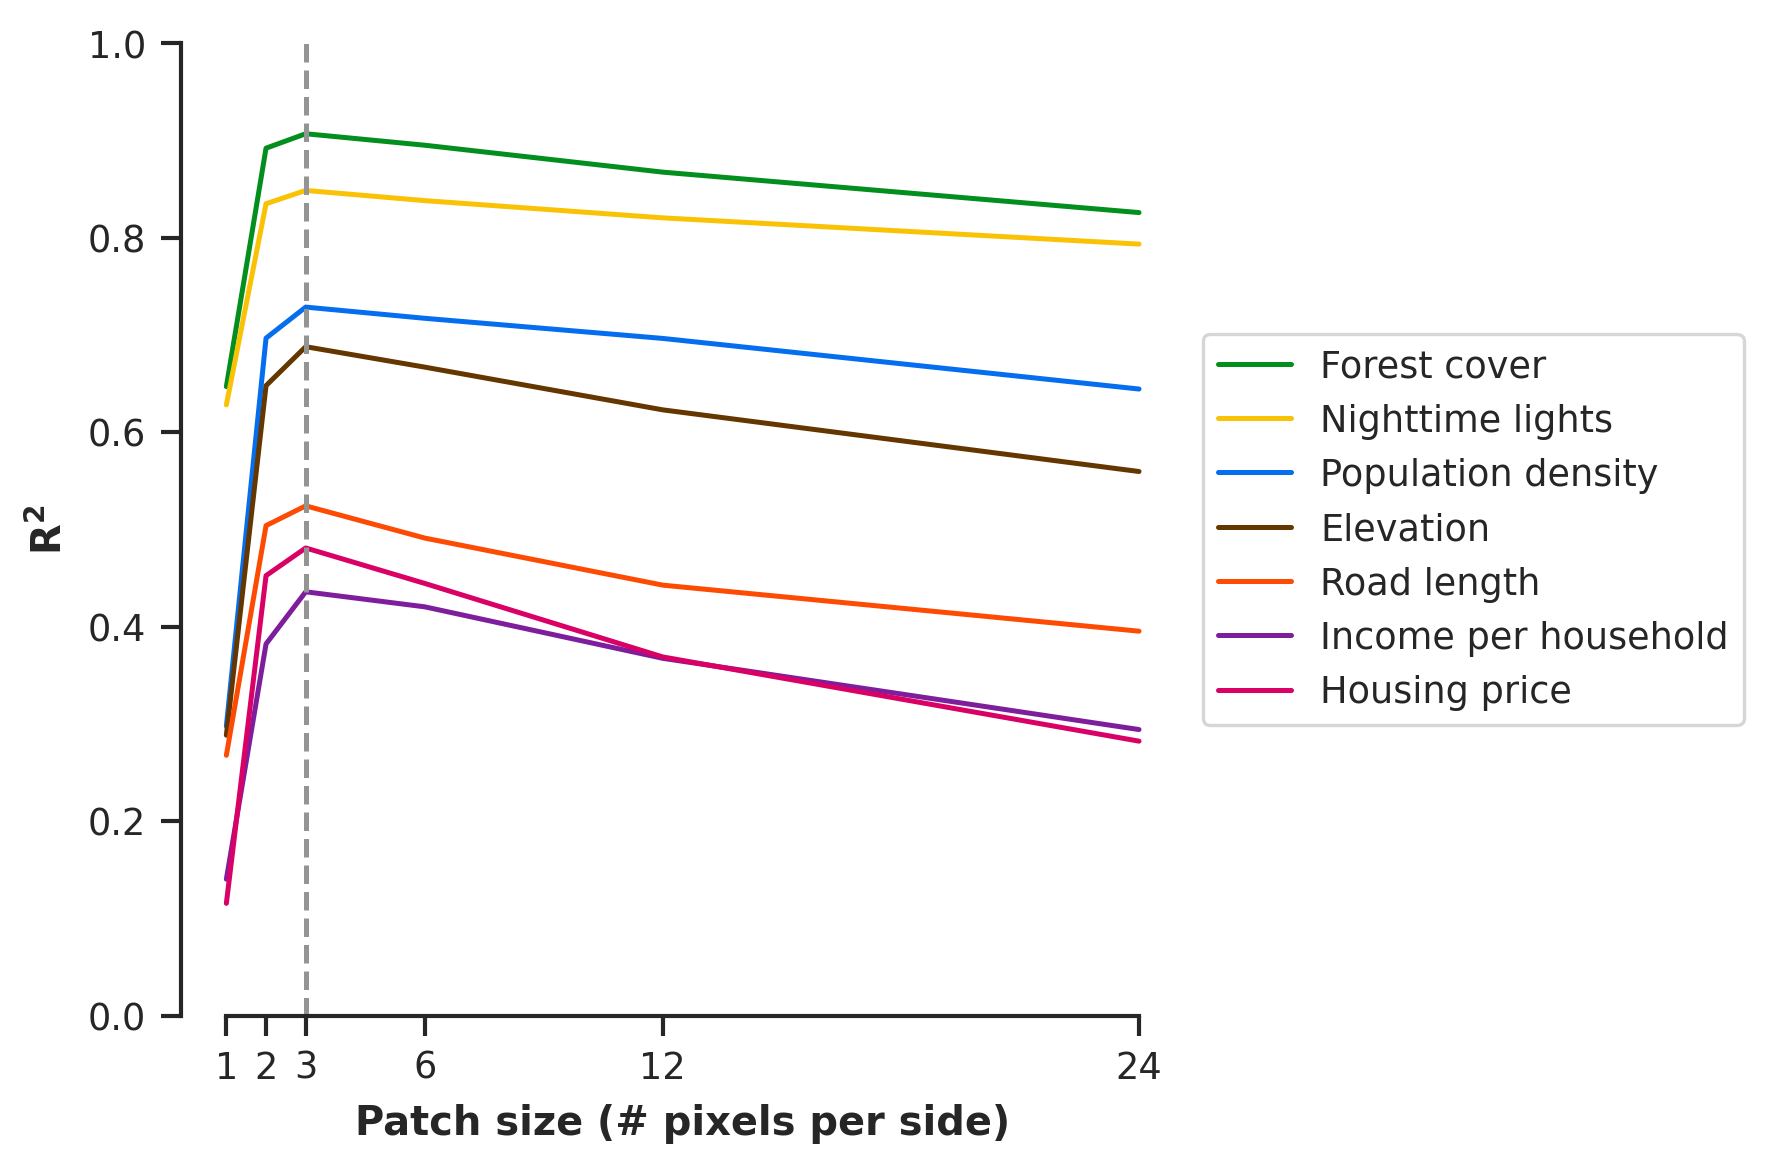

In [12]:
fig, ax = plt.subplots(1, 1, dpi=300, tight_layout=True)

to_plot = pd.read_csv(fn, index_col=[0, 1]).r2_score.unstack(level="label")
order = to_plot.iloc[-1].sort_values(ascending=False).index.values
to_plot = to_plot.reindex(columns=order)
to_plot.columns = [getattr(c, i)["disp_name"] for i in order]
colors = [getattr(c, i)["color"] for i in order]

to_plot.plot(color=colors, legend=False, ax=ax)
plt.ylim(0, 1)
plt.xticks(to_plot.index.values)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.axvline(3, color=sns.xkcd_rgb["grey"], linestyle="--")
sns.despine(trim=True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Patch size (# pixels per side)", weight="bold")
plt.ylabel(r"$\bf{R^2}$")

plt.savefig(figdir / f"FigS6{subset_str}.pdf", dpi="figure")